# Running Tests
___
1. Reading in dataset and preparing it.
2. Test naive KNN implementations.
3. Test Ball Tree implementation.
4. Weighting functions.
5. Comparing hyperparameters for KNN classifier.
6. Comparing hyperparameters for KNN regressor.
7. Target function.
8. Extension.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import arff
from HelperFunctions import *
from WeightFunctions import *
from NaiveKNNClassifier import *
from NaiveKNNRegressor import *
from TestNaiveKNN import *

In [2]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, BallTree
#from labelEncoder import *
from scaler import *

# 1. Read in datasets
___
Read in both the ionosphere and autos dataset and prepare them.

In [3]:
# Read in the ionosphere dataset
ionosphere = arff.loadarff('../ionosphere.arff')
ionosphere = pd.DataFrame(ionosphere[0])

# Drop useless attribute
ionosphere = ionosphere.drop(columns='a02') # gives no information

# Extract X and y as numpy arrays
ionosphere = ionosphere.to_numpy()
X1 = ionosphere[:, :-1].astype(np.float64)
y1 = ionosphere[:, -1]

# Map the labels 'b' and 'g' to 0 and 1 respectively
labels, y1 = np.unique(y1, return_inverse=True) # labels[0] = 'b', labels[1] = 'g'

print('ionosphere dataset:')
print('X shape:', X1.shape)
print('y shape:', y1.shape)

ionosphere dataset:
X shape: (351, 33)
y shape: (351,)


In [4]:
# Read in the autos dataset
autos = arff.loadarff('../autos.arff')
autos = pd.DataFrame(autos[0])
    
# Remove any categorical labels
autos.drop(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
            'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 
            'fuel-system'], axis=1, inplace=True)

# Remove missing values
autos = autos.dropna()

# Extract X and y
y2 = autos['price'].to_numpy()
X2 = autos.drop('price', axis=1)

# Scale and normalise
from scaler import MinMaxScaler
scaler = MinMaxScaler()
X2 = scaler.fit_transform(X2)
print('autos dataset:')
print('X shape:', X2.shape)
print('y shape:', y2.shape)

autos dataset:
X shape: (160, 15)
y shape: (160,)


# 2. Naive KNN Implementation Tests
___
In this section we test different implementations of the naive KNN algorithm. Based on what functions and libraries we use, the performance can differ drastically. In the TestNaiveKNN.py file we have defined the euclidean distance and manhattan distance metric, and a class that compares the different implementations of the naive KNN algorithm. Below I briefly describe the different naive KNN implementations we tested:

__Approach 1:__
Uses a for-loop to go through all the training examples and calculates its distance from the test example. Appends the result and its corresponding label as a pair into a list. Then sorts the list by the distance and returns the most common label from the first k elements in the list. Does not use numpy.

__Approach 2:__
Uses a for-loop to go through all the training examples and calculates its distance from the test example. Pushes the result ant its corresponding label into a min-heap. Then pops k elements from the heap and returns the most common label among them. Does not use numpy.

__Approach 3:__
Uses numpy matrix operations to calculate the distance from the test example to all training examples. Then uses the
stack operation to pair the distances with their label into a new numpy array. Then sorts the array by the distance and returns the most common label from the first k elements in the the array.

__Approach 4:__
The same as the third approach but instead of sorting, it uses a for-loop to push all distance/label pairs onto a min-heap. Then pops k elements from the heap and returns the most common label among them.


In [5]:
# Import the functions and classes needed to test the different implementations
from TestNaiveKNN import *

In [6]:
# Run our tests on the 4 different naive KNN implementations for 5 random test examples with k=3 and the euclidean distance metric.
X_test = X1[np.random.randint(X1.shape[0], size=5), :]
classifier = TestKNNClassifier(n_neighbours=3)
classifier.fit(X1, y1)
%timeit classifier.predict1(X_test)
%timeit classifier.predict2(X_test)
%timeit classifier.predict3(X_test)
%timeit classifier.predict4(X_test)

# Compare to the SKlearn implementation
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X1, y1)
classifier.predict(X_test)
%timeit classifier.predict(X_test)

29.9 ms ± 738 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
797 µs ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.58 ms ± 83.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.13 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# 3. Ball Tree KNN Implementation Tests
___

In [7]:
from scipy import stats

# Test our implementations
X_test = X1[np.random.randint(X1.shape[0], size=5), :]
#BallTree Implementation
#%timeit classifier.predict(X_test)

# Test sklearn implementation
for leaf in np.arange(1, 100, 10): # test with different leaf sizes
    %timeit treesk = BallTree(X1, leaf_size=leaf); _, ind = treesk.query(X_test, k=3); preds = stats.mode(y1[ind],axis=1)

2.85 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.97 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.48 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.23 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.11 ms ± 86.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.13 ms ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.11 ms ± 84.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.13 ms ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.93 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# 4. Comparing Weighting Functions
___
For this assignment we test a variety of weighting functions. The weighting functions we test are shown below:
1. __Inverse distance:__ 1 / (d + ε)
2. __Inverse distance squared:__ 1 / (d<sup>2</sup> + ε)
3. __Exponential:__ e<sup>-d</sup>
4. __Dudani:__ (max - d) / (max - min + ε) if d ≠ min, else 1 where min is the distance to closest training example and max is the distance to kth closest training example.
              

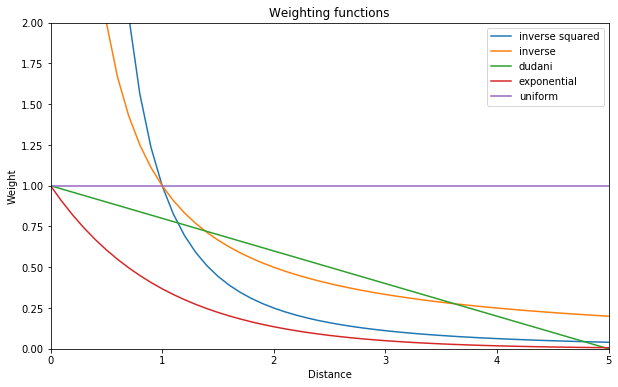

In [8]:
# Graph the weights vs. distance for different weighting functions
dist = np.arange(0,5.1,0.1)
plt.figure(figsize=(10,6))
plt.plot(dist, inverse_squared_dist(dist), label='inverse squared')
plt.plot(dist, inverse_dist(dist), label='inverse')
plt.plot(dist, dudani(dist), label='dudani')
plt.plot(dist, exponential(dist), label='exponential')
plt.plot(dist, uniform(dist), label='uniform')

# Label plot
plt.title('Weighting functions')
plt.xlabel('Distance')
plt.ylabel('Weight')
plt.axis([0, 5, 0, 2])
plt.legend()
plt.show()

# 5. Comparing Hyperparameters for KNN Classification
___
Below we evaluate the KNN classifier using leave-one-out cross-validation. The hyperparameters that we test are the distance metric, the number of neighbours, and the weighting factor.

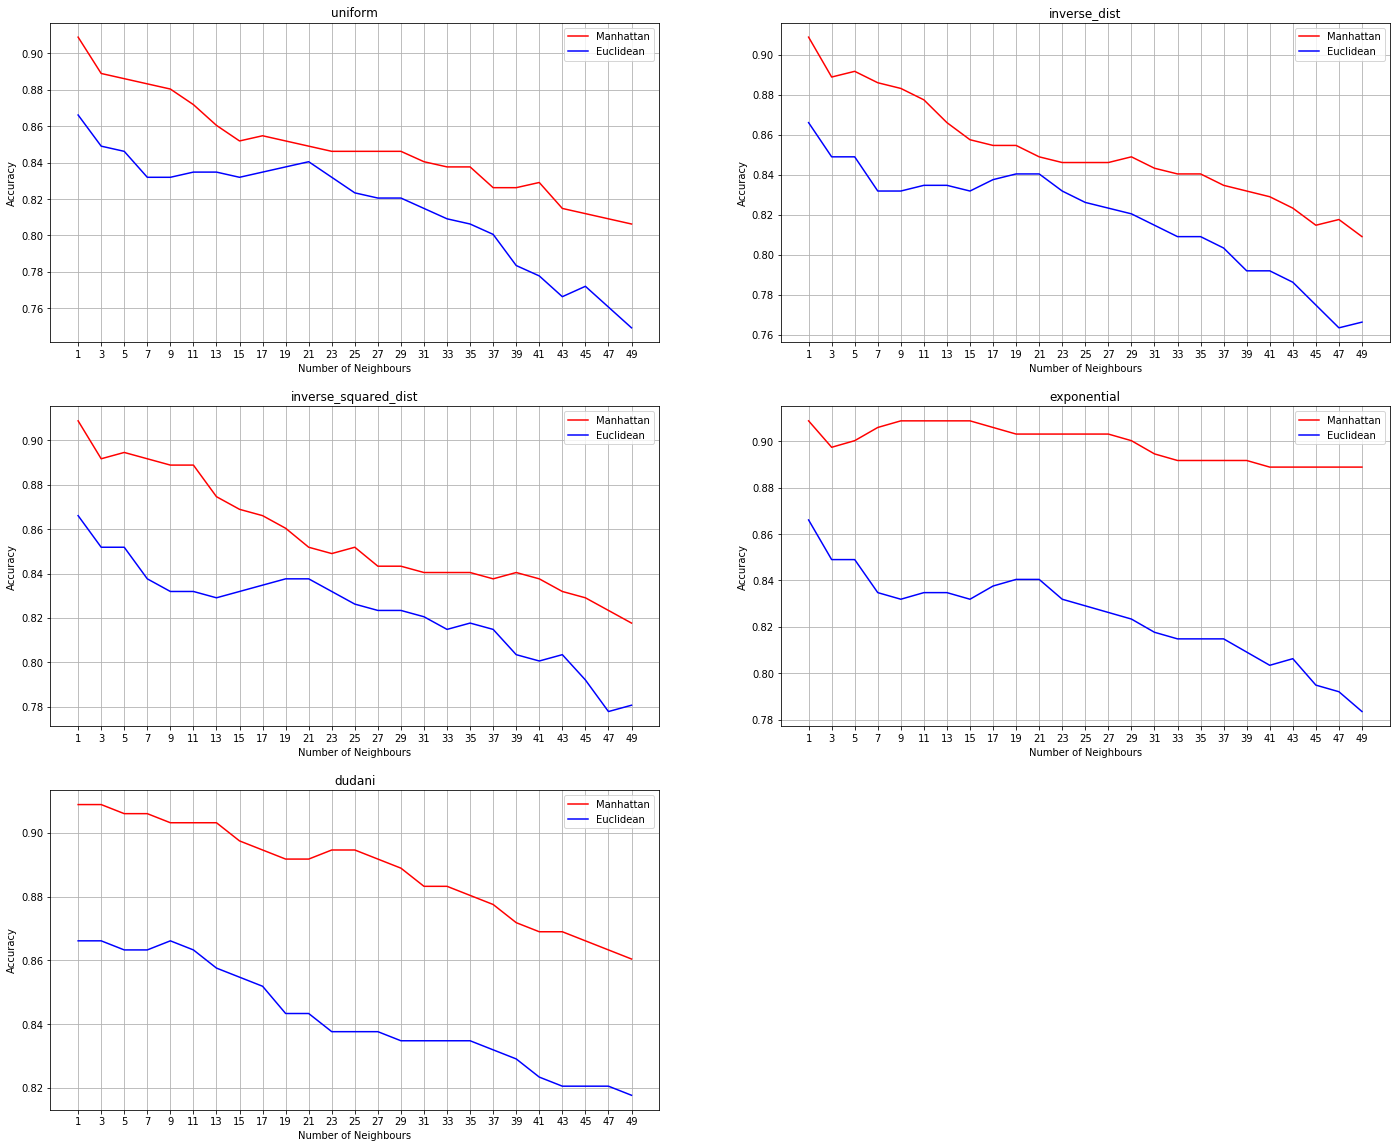

In [9]:
# Plot graphs that compare the performance of the classifier over a range of hyperparameters

# Range of k values to test
k_range = range(1, 50, 2)

# Weighting functions to test
weight_functions = [uniform, inverse_dist, inverse_squared_dist, exponential, dudani]

# Evaluate the classifier for different weighting functions
plt.figure(figsize=(24, 20))
for i in range(len(weight_functions)):
    manhattan_accuracies, euclidean_accuracies = get_model_results(SimpleKNNClassifier, k_range, weight_functions[i], X1, y1)
    plt.subplot(3, 2, i + 1)
    plt.plot(k_range, manhattan_accuracies, 'r-', label='Manhattan')
    plt.plot(k_range, euclidean_accuracies, 'b-', label='Euclidean')
    plt.xlabel('Number of Neighbours')
    plt.ylabel('Accuracy')
    plt.xticks(k_range)
    plt.title(weight_functions[i].__name__)
    plt.grid()
    plt.legend()

# 6. Comparing Hyperparameters for KNN Regression
___
Below we evaluate the KNN regressor using leave-one-out cross-validation. The hyperparameters that we test are the distance metric, the number of neighbours, and the weighting factor.

In [ ]:
# Plot graphs that compare the performance of the regressor over a range of hyperparameters

# Range of k values to test
k_range = range(1, 50, 2)

# Weighting functions to test
weight_functions = [uniform, inverse_dist, inverse_squared_dist, exponential, dudani]

# Evaluate the regressor for different weighting functions
plt.figure(figsize=(24, 20))
for i in range(len(weight_functions)):
    manhattan_errors, euclidean_errors = get_model_results(SimpleKNNRegressor, k_range, weight_functions[i], X2, y2)
    plt.subplot(3, 2, i + 1)
    plt.plot(k_range, manhattan_errors, 'r-', label='Manhattan')
    plt.plot(k_range, euclidean_errors, 'b-', label='Euclidean')
    plt.xlabel('Number of Neighbours')
    plt.ylabel('Error')
    plt.xticks(k_range)
    plt.title(weight_functions[i].__name__)
    plt.grid()
    plt.legend()

# 7. Target Function testing
___

In [3]:
from target import *

In [4]:
# Generate target functions
np.random.seed(201923)
p = 0.5
num_samples = 351
num_f = 33
mean = generate_mean(num_f) # target functions are going to be using the same mean

# Target function for class 0
cov0 = generate_covariance_matrix(num_f)
target0 = TargetFunction(mean, cov0, num_f, 0)

# Target function for class 1
cov1 = generate_covariance_matrix(num_f)
target1 = TargetFunction(mean, cov1, num_f, 1)

print('------------------------------')
print(f'Generating data based on target function {p} probability between the two classes...')

# Generate the dataset
class_0, class_1 = generate_dataset(p, 10000, target0, target1)
# print(class_0.shape, class_1.shape)
# print(f'First 2 data points of class 0: \n{class_0[:2]}')
# print(f'First 2 data points of class 1: \n{class_1[:2]}')

print('------------------------------')
print('Creating data set')
X3, y3 = make_useable_dataset(class_0, 0, class_1, 1)
# print(f'First 2 data points of x_data:\n{x_data[:2]}')
# print(f'First 2 data points labels:\n{labels[:2]}')

# Get Bayes error rate
err = calc_bayes_error(X3, y3, target0, p, target1, (1-p))
print(f'Bayes error rate on this dataset: {err*100:.20f}%')

# Get the first 351 samples
X3 = X3[:num_samples]
y3 = y3[:num_samples]

------------------------------
Generating data based on target function 0.5 probability between the two classes...
------------------------------
Creating data set
Bayes error rate on this dataset: 0.00279852947334884548%


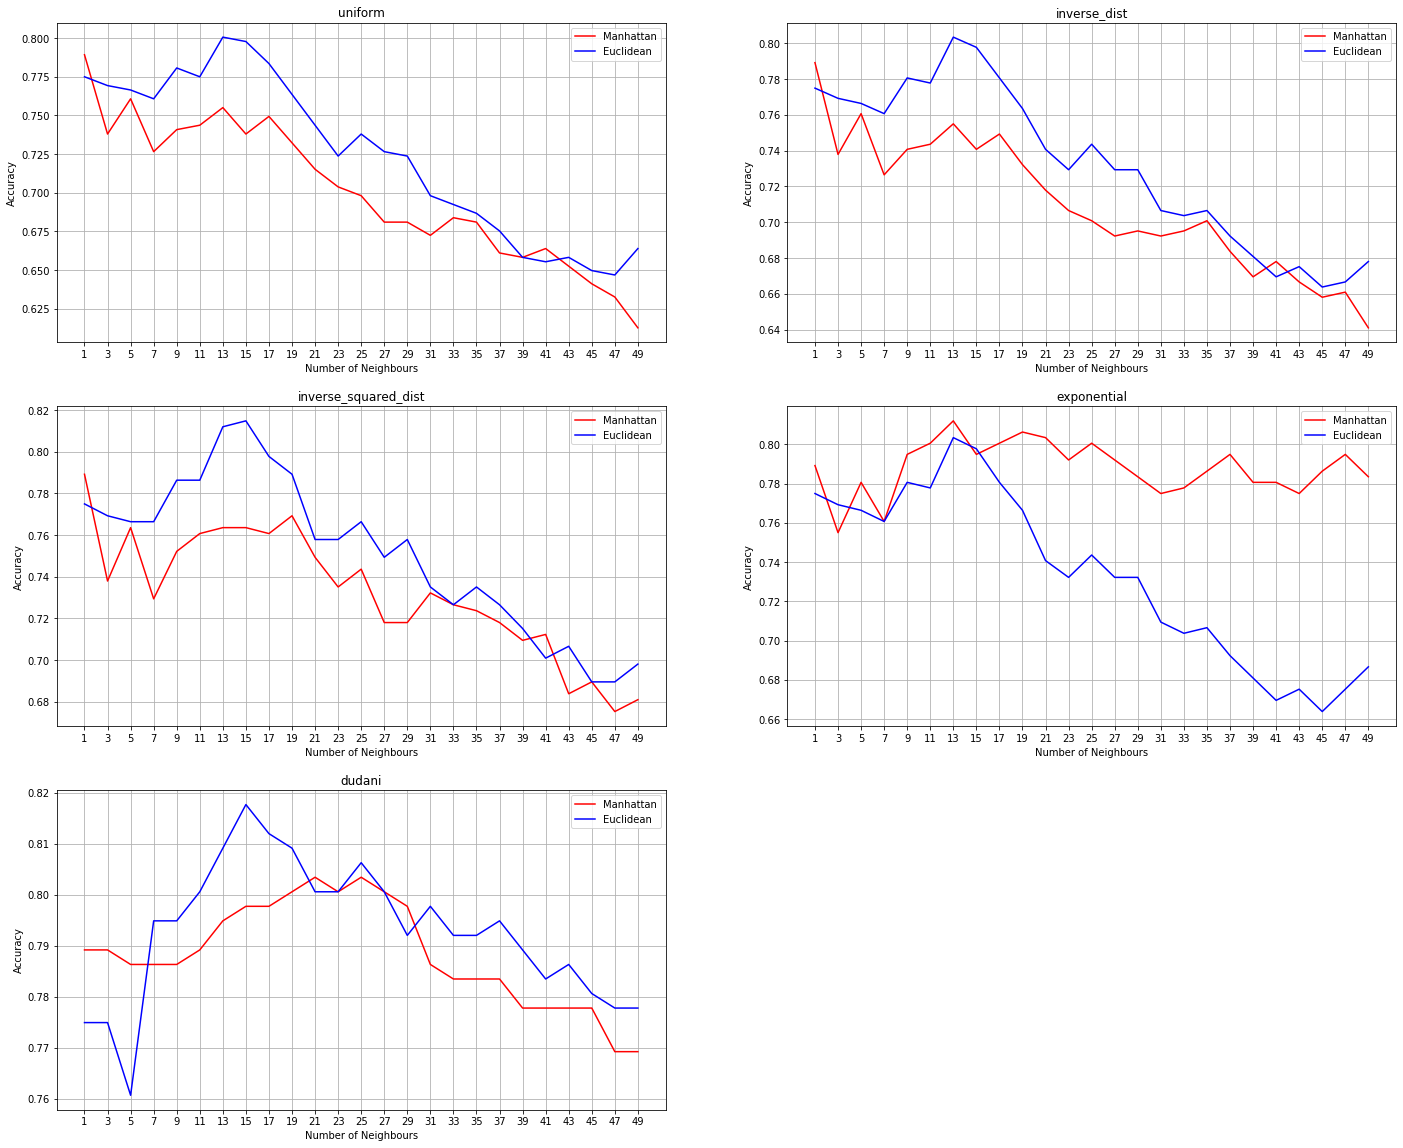

In [5]:
# Plot graphs that compare the performance of the classifier on the generated dataset over a range of hyperparameters

# Range of k values to test
k_range = range(1, 50, 2)

# Weighting functions to test
weight_functions = [uniform, inverse_dist, inverse_squared_dist, exponential, dudani]

# Evaluate the classifier for different weighting functions
plt.figure(figsize=(24, 20))
for i in range(len(weight_functions)):
    manhattan_accuracies, euclidean_accuracies = get_model_results(SimpleKNNClassifier, k_range, weight_functions[i], X3, y3)
    plt.subplot(3, 2, i + 1)
    plt.plot(k_range, manhattan_accuracies, 'r-', label='Manhattan')
    plt.plot(k_range, euclidean_accuracies, 'b-', label='Euclidean')
    plt.xlabel('Number of Neighbours')
    plt.ylabel('Accuracy')
    plt.xticks(k_range)
    plt.title(weight_functions[i].__name__)
    plt.grid()
    plt.legend()

# 8. Extension (PCA and Visualisation)
___
As an extension we implemented Principal Component Analysis to reduce the dimensions of the datasets so that they can be visualized. The implementation of PCA is in the HelperFunctions.py file. Once the dimensions have been reduced we can plot the data on a 2D graph. Below we plot the decision boundary for the KNN classifier on the ionosphere dataset, and the prediction curve for the KNN regressor on the autos dataset.

In [ ]:
# Visualize the KNN classifier on the ionosphere dataset

# Reduce dimensions 
X_new = PCA(X1, n_components=2)

# Train classifier on transformed data
k_range = range(1, 8, 2)
plt.figure(figsize=(24, 20))
for i, k in enumerate(k_range):
    classifier = SimpleKNNClassifier(n_neighbours=k, dist_metric='euclidean', weight_func=uniform)
    classifier.fit(X_new, y1)

    # Plot data points
    plt.subplot(2, 2, i + 1)
    plt.plot(X_new[y1==0, 0], X_new[y1==0, 1], 'ro', label='y = b')
    plt.plot(X_new[y1==1, 0], X_new[y1==1, 1], 'bo', label='y = g')

    # Plot boundary
    X_grid1, X_grid2 = np.meshgrid(np.linspace(min(X_new[:,0])-1, max(X_new[:,0])+1, 1000), 
                                   np.linspace(min(X_new[:,1])-1, max(X_new[:,1])+1, 1000))

    y_grid = classifier.predict(np.c_[X_grid1.ravel(), X_grid2.ravel()])

    plt.contourf(X_grid1, X_grid2, y_grid.reshape(X_grid1.shape),
                alpha = 0.2, cmap = ListedColormap(('red', 'blue')))

    # Label plot
    plt.title(f'KNN Classifier (k={k})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()

In [ ]:
# Visualize the KNN classifier on the ionosphere dataset

# Visualizing the regressor
X_new = PCA(X2, n_components = 1) # note: much of the variance is lost with so few principal components

# Train classifier on transformed data
k_range = range(1, 8, 2)
plt.figure(figsize=(24, 20))
for i, k in enumerate(k_range):
    regressor = SimpleKNNRegressor(n_neighbours=k, dist_metric='euclidean', weight_func=uniform)
    regressor.fit(X_new, y2)

    # Plot data points
    plt.subplot(2, 2, i + 1)
    plt.plot(X_new, y2, 'ro')

    # Plot regression curve
    X_grid = np.linspace(min(X_new), max(X_new), 1000).reshape(-1,1)
    plt.plot(X_grid, regressor.predict(X_grid), 'b-')

    # Label plot
    plt.title(f'KNN Regressor (k={k})')
    plt.xlabel('Component 1')
    plt.ylabel('Price')
